# **DESAFIO 3 G2** 
# **Dataset Imagenes Covid-19 - Modelo de clasificacion supervisado.**
---

<a id="section_toc"></a> 
## Tabla de Contenidos

[Intro](#section_toc)

Armado y presentacion de dataset

$\hspace{.5cm}$[Importaciones y carga de bibliotecas](#sec_imp)

$\hspace{.5cm}$[Analisis previos y observacion de variables](#sec_apo)

$\hspace{.9cm}$[Inspeccion de variables](#sec_apo_ds)

$\hspace{.9cm}$[Caracteristicas generales del dataset](#sec_apo_nc)

Implementacion de modelos de clasificacion supervisados

$\hspace{.5cm}$[Armado de set de entrenamiento y testing](#sec_set)
  
$\hspace{.5cm}$[KNeighborsClassifier](#sec_knn)

$\hspace{.9cm}$[Analisis](#sec_knn_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_knn_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_knn_eval)

$\hspace{.5cm}$[Gaussian Naive Bayes](#sec_gnb)

$\hspace{.9cm}$[Analisis](#sec_gnb_a)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_gnb_eval)

$\hspace{.5cm}$[Logistic Regression](#sec_lr)

$\hspace{.9cm}$[Analisis](#sec_lr_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_lr_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_lr_eval)

Automatizacion de procesos

$\hspace{.5cm}$[Pipelines](#sec_pipelines)

---

## Armado y presentacion de dataset

<a id="sec_imp"></a> 
### Importaciones y carga de bibliotecas

[volver a TOC](#section_toc)

In [1]:
!pip install opencv-python

#### Importacion de bibliotecas generales

In [2]:
import os
import sys
import re

In [3]:
import pandas as pd
import numpy as np

In [4]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

#### Importacion de librerias para armado y testeo de modelos

In [5]:
# operaciones sobre variables
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score

# modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# normalizacion de variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

#### Variables globales

In [6]:
# path relativo al repositorio de imagenes
this_path = os.path.dirname('.')
rel_dataset_path = '../../data/xrays_dataset_completo/'

# path absoluto al repositorio de imagenes
abs_dataset_path = os.path.abspath(os.path.join(this_path, rel_dataset_path))

# path absoluto a dataset de training y a dataset testing
# photos1
photos1_dataset_path = os.path.join(abs_dataset_path, "photos1")
# photos2
photos2_dataset_path = os.path.join(abs_dataset_path, "photos2")
# photos3
photos3_dataset_path = os.path.join(abs_dataset_path, "photos3")

# expresion regular para buscar solamente imagenes
pat = '(jpeg|jpg|png)$'
reg = re.compile(pat, flags = re.IGNORECASE)

<a id="sec_apo"></a> 
### Analisis previos y observacion de variables

[volver a TOC](#section_toc)

Fuente de repositorio de imagenes:

* [Covid-19 Image Dataset](https://www.kaggle.com/pranavraikokte/covid19-image-dataset). Usability: 8.8
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Las imagenes fueron liberadas por la Universidad de Montreal.


* [COVID19 High quality images](https://www.kaggle.com/theroyakash/covid19). Usability: 5.0
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Fuente no oficial. Imagenes extraidas desde sitios publicos mediante Web Scrapping.

Ambos datasets se encuentran dispuestos en una estructura de directorios que comienza con la separacion de carpetas de training y testing. Luego a partir de estas carpetas se crean nuevas carpetas que identifican los casos de Covid, Neumonia y casos sin afecciones.

Para poder distribuir de forma uniforme el set de datos utilizados para testing y training, unificamos ambos repositorios en la siguiente estructura de directorios:

<code>
$ tree -d .

.
├── photos1
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
├── photos2
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
└── photos3
    ├── Covid
    ├── Normal
    └── Viral Pneumonia
</code>

Con el armado del dataset delegaremos luego en los metodos `train_test_split()` y `StratifiedKFold()` de la bilbioteca scikit-learn la distribucion del set de datos para training y testing.

<a id="sec_apo_ds"></a> 
#### Inspeccion de variables

[volver a TOC](#section_toc)

**Comprobacion de carga de ruta de imagenes desde el sistema operativo**

In [7]:
path_label = [path for path in os.listdir(photos1_dataset_path)]

In [8]:
print(path_label)

['covid', 'normal', 'viral neumonia']


#### Inspeccion de imagenes

**Coronavirus**

A continuacion se presentan imagenes de ejemplo de pacientes con Covid-19. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [9]:
imcor1 = cv2.imread(rel_dataset_path + '/photos1/Covid/0100.jpeg', cv2.COLOR_BGR2GRAY)
imcor2 = cv2.imread(rel_dataset_path + '/photos1/Covid/0102.jpeg', cv2.COLOR_BGR2GRAY)
imcor3 = cv2.imread(rel_dataset_path + '/photos1/Covid/0105.png', cv2.COLOR_BGR2GRAY)
imcor4 = cv2.imread(rel_dataset_path + '/photos1/Covid/0106.jpeg', cv2.COLOR_BGR2GRAY)

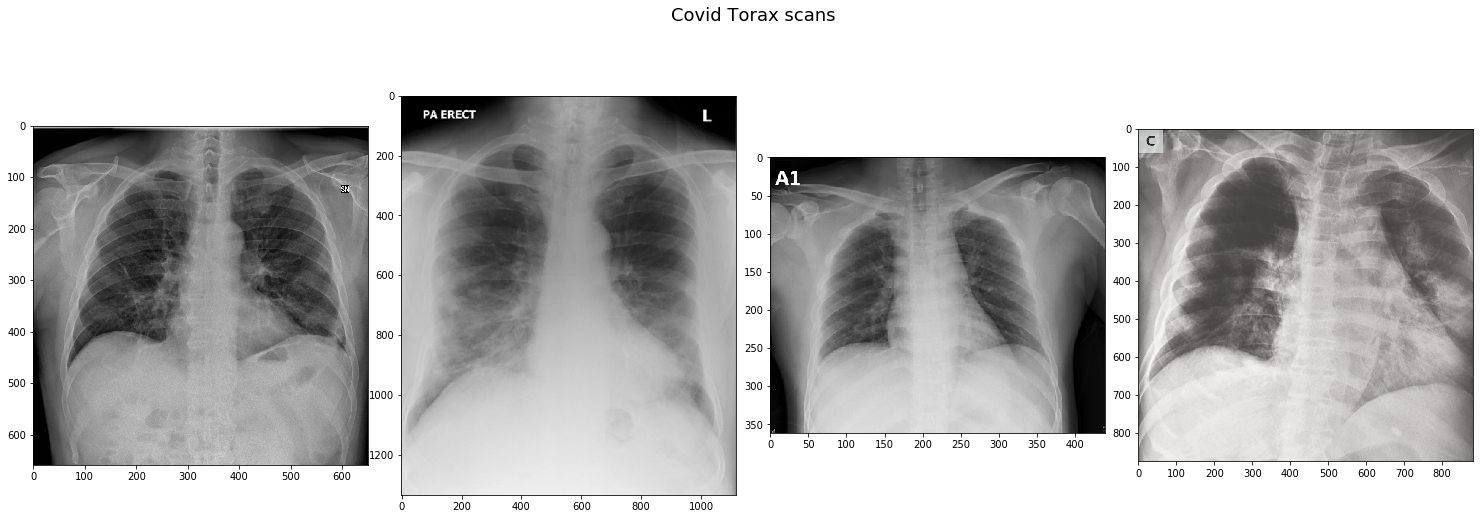

In [10]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Covid Torax scans', y=0.70, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imcor1)
axs[1].imshow(imcor2)
axs[2].imshow(imcor3)
axs[3].imshow(imcor4)
plt.show()

**Neumonia**

A continuacion se presentan imagenes de ejemplo de pacientes con Neumonia. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [11]:
imneu1 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0101.jpeg', cv2.COLOR_BGR2GRAY)
imneu2 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0102.jpeg', cv2.COLOR_BGR2GRAY)
imneu3 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0103.jpeg', cv2.COLOR_BGR2GRAY)
imneu4 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0104.jpeg', cv2.COLOR_BGR2GRAY)

TypeError: Image data cannot be converted to float

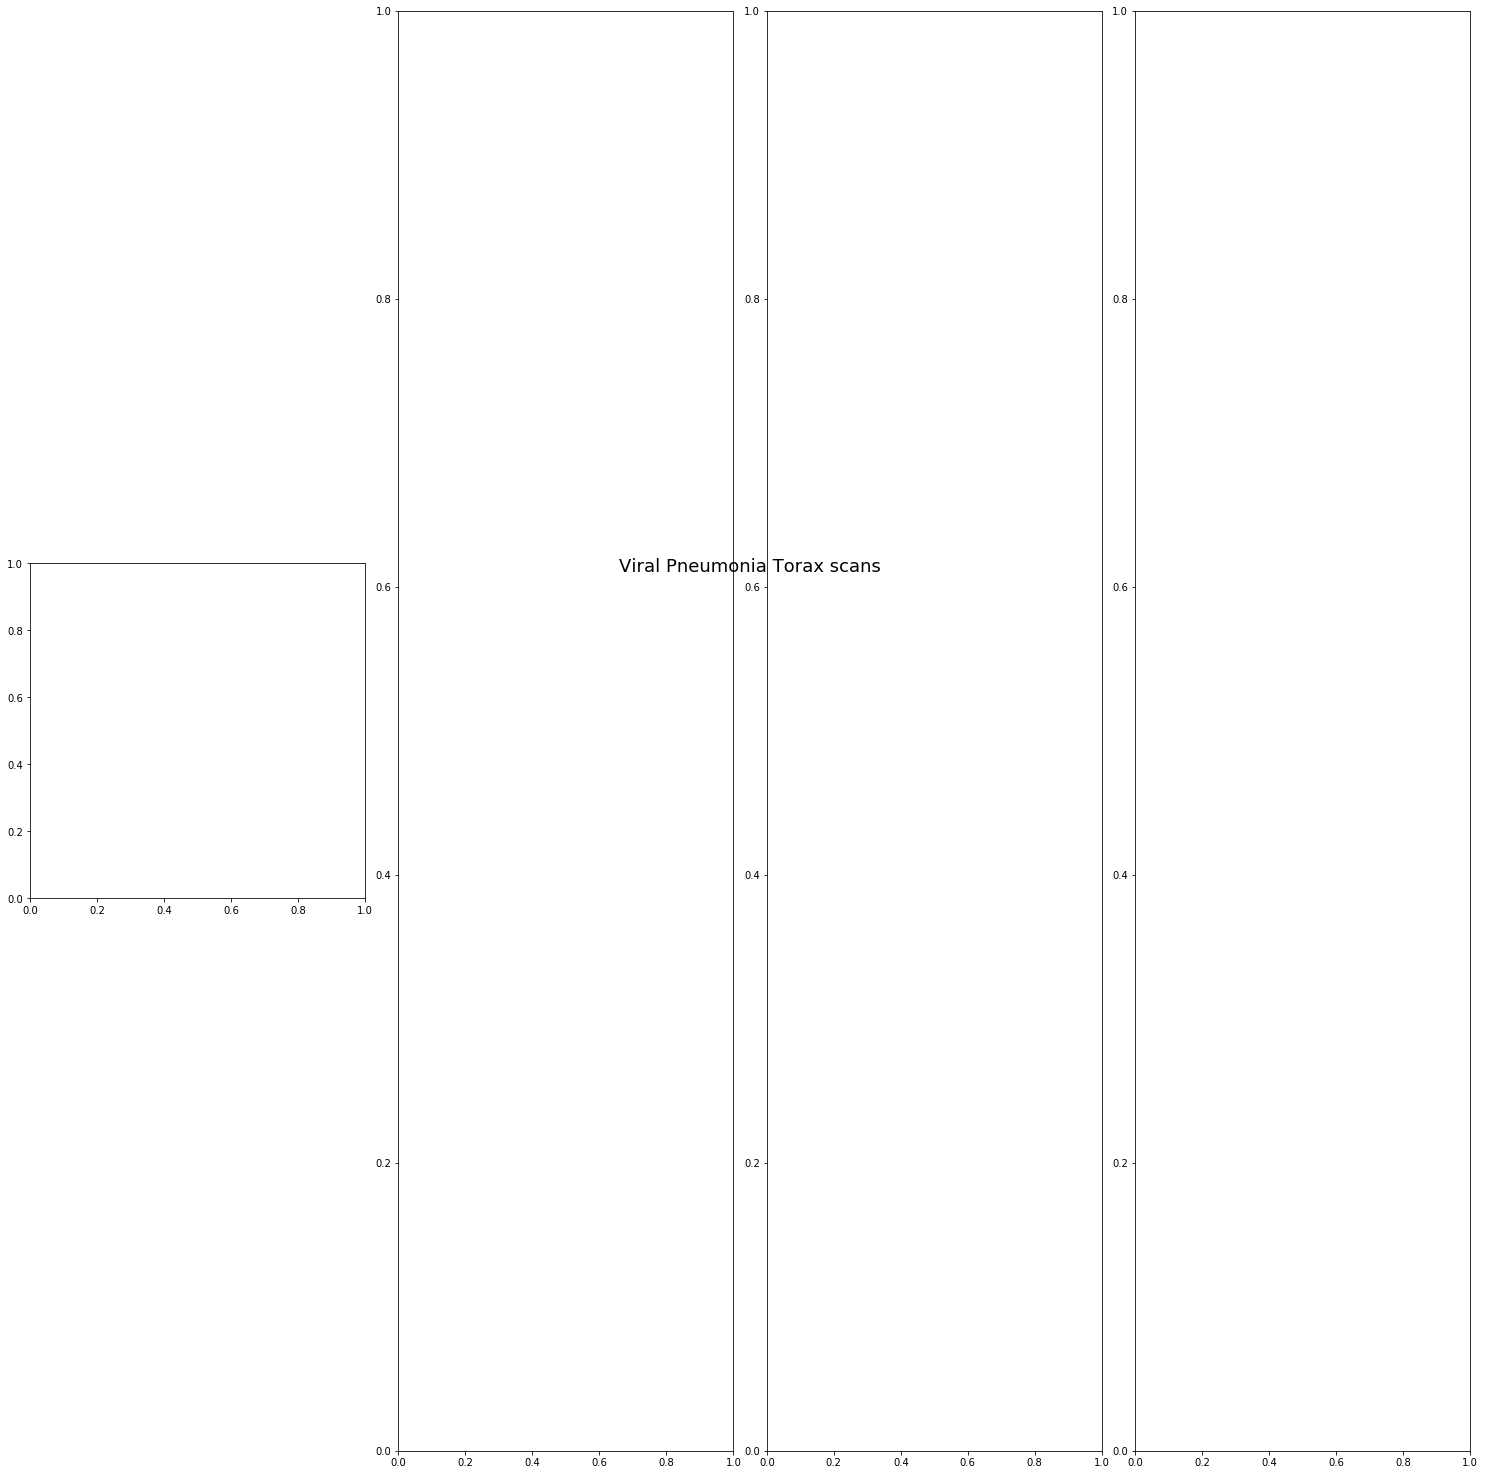

In [12]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Viral Pneumonia Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imneu1)
axs[1].imshow(imneu2)
axs[2].imshow(imneu3)
axs[3].imshow(imneu4)
plt.show()

**Normal**

A continuacion se presentan imagenes sin ninguna afeccion pulmonar. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [ ]:
imnor1 = cv2.imread(rel_dataset_path + '/photos1/Normal/0101.jpeg', cv2.COLOR_BGR2GRAY)
imnor2 = cv2.imread(rel_dataset_path + '/photos1/Normal/0102.jpeg', cv2.COLOR_BGR2GRAY)
imnor3 = cv2.imread(rel_dataset_path + '/photos1/Normal/0103.jpeg', cv2.COLOR_BGR2GRAY)
imnor4 = cv2.imread(rel_dataset_path + '/photos1/Normal/0105.jpeg', cv2.COLOR_BGR2GRAY)

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Normal Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imnor1)
axs[1].imshow(imnor2)
axs[2].imshow(imnor3)
axs[3].imshow(imnor4)
plt.show()

<a id="sec_apo_ds"></a> 
### Caracteristicas generales del dataset.

[volver a TOC](#section_toc)

**Parametros de tratamiento general sobre las imagenes**

Analisis segun las siguientes condiciones:
   
 * Tamaño de imagenes ajustados a 100 pixeles x 100 pixeles.
 * Uso de escala de grises.
 * Uso de [**Biblioteca OpenCV**](https://opencv.org/)
 
La biblioteca OpenCV permitio facilmente trabajar con el mapa de bits de cada pixel gracias a su integracion con Numpy. A traves de la utilizacion de metodos de OpenCV podemos generar una matriz de np.array con la distribucion de colores de cada pixel.
A traves del metodo `flatten()` de OpenCV es posible transformar la matriz np.array en un vector. 

Entonces cada vector constituira una imangen de 100 x 100 pixeles distribuida en una sola dimension.

**Imagen ejemplo**

In [ ]:
imgtest = cv2.imread(rel_dataset_path + '/photos1/Covid/0100.jpeg', cv2.IMREAD_COLOR)

In [ ]:
imgtest = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY)

In [ ]:
imgtest = cv2.resize(imgtest, (100,100))

In [ ]:
plt.imshow(imgtest)
plt.xlabel('pixeles horizontales')
plt.ylabel('pixeles verticales')
plt.title('Imagen a representar en 10000 pixeles')
plt.show()

In [ ]:
imgtest.shape

In [ ]:
imgtest.flatten().shape

**Armado de dataset**

La funcion `new_dataset()` se desarrollo para poder transformar los distintos repositorios de imagenes en una matriz que contenga una lista de vectores correspondiente a cada imagen a analizar.

In [8]:
def new_dataset(dataset_path):
    '''
    creacion de nuevo dataset a partir de repositorio de imagenes
    dataset_path: ruta absoluta donde se encuentran las imagenes, test o train
    salida: tupla con:
        * matriz de dos dimensiones con mapa de bits de cada imagen (cada registro o lista de una dimension es una imagen) - Feature
        * lista de una dimension con valores numericos que representan la clase a la que pertenece la imagen - Target
        * lista de una dimension con las etiquetas de clase a la que pertenece cada imagen
    '''
    imgs_label = []
    imgs = []
    for pathlabel in os.listdir(dataset_path):
        label = os.path.join(dataset_path, pathlabel)
        for file in os.listdir(label):
            if re.search(pat, file) is not None:
                img = cv2.imread(os.path.join(label, file), cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100,100))
                img = img.flatten()
                imgs.append(img)
                imgs_label.append(pathlabel)
                
    label_to_id_dict = {v:i for i,v in enumerate(np.unique(imgs_label))}
    label_ids = np.array([label_to_id_dict[x] for x in imgs_label])
    
    return np.array(imgs), label_ids, np.array(imgs_label)

### Preparacion del dataset

Unificacion de set de train y testing para aplicar una estrategia de separacion a traves de los metodos de scikit learn. Se busca mantener la proporcionalidad de la clases de la variable target.

In [9]:
photos1_X, photos1_y, photos1_labels = new_dataset(photos1_dataset_path)
photos2_X, photos2_y, photos2_labels = new_dataset(photos2_dataset_path)
photos3_X, photos3_y, photos3_labels = new_dataset(photos3_dataset_path)

**Features**

Matriz que contiene en cada vector la distribucion de colores por pixel de cada imagen.

In [15]:
photos1_X

array([[ 12,   8,   4, ...,   9,  14,  13],
       [ 53,  53,  53, ...,  93,  86,  81],
       [163, 156, 153, ...,  36,  22,   4],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

**Target**

Labels que hacen referencia a que clase pertenece cada vector.

Entonces:
 * 0 - Corresponde a los enfermos con COVID: **_Covid_**.
 * 1 - Corresponde a los pacientes saludables: **_Normal_**.
 * 2 - Corresponde a los enfermos con Neumonía: **_Viral Pneumonia_**.

In [16]:
photos1_labels

array(['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal

In [17]:
photos1_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Estructura de cada set de imagenes cargado.

In [10]:
display(photos1_X.shape, photos1_y.shape, photos1_labels.shape)
display(photos2_X.shape, photos2_y.shape, photos2_labels.shape)
display(photos3_X.shape, photos3_y.shape, photos3_labels.shape)

(353, 10000)

(353,)

(353,)

(66, 10000)

(66,)

(66,)

(251, 10000)

(251,)

(251,)

**Features y target como objetos de pandas**

La estructura final del dataset de features esta conformado por:

* 670 imagenes estructuradas en vectores.
* 10000 features correspondientes a la escala de colores de cada pixel representado entre 0 a 255.

In [10]:
numpy_append = np.append(photos1_X, photos2_X, axis=0)
data_features = pd.DataFrame(np.append(numpy_append, photos3_X, axis=0))

In [20]:
data_features

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,12,8,4,7,7,5,0,2,2,3,...,0,0,0,3,1,7,9,9,14,13
1,53,53,53,73,74,82,71,73,79,83,...,125,121,112,112,114,107,102,93,86,81
2,163,156,153,148,149,147,144,145,143,141,...,109,112,124,99,91,77,53,36,22,4
3,74,88,91,100,84,91,80,52,56,64,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,220,219,218,212,209,210,204,197,186,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,77,118,121,34,48,76,33,53,50,41,...,198,178,125,143,62,41,29,10,5,0
666,40,38,32,28,33,48,56,79,38,22,...,136,111,71,48,26,19,9,3,0,0
667,14,22,89,62,50,47,53,52,62,84,...,166,121,105,76,29,7,0,0,0,0
668,7,7,7,7,7,7,4,0,0,0,...,11,0,0,0,0,0,0,0,0,0


**Target**

In [11]:
numpy_append = np.append(photos1_y, photos2_y, axis=0)
data_target = pd.Series(np.append(numpy_append, photos3_y, axis=0))

**Dataset final**

In [22]:
data_features.shape, data_target.shape

((670, 10000), (670,))

---

## Implementacion de modelos de clasificacion supervisados

<a id="sec_set"></a> 
### Armado de set de entrenamiento y testing

[volver a TOC](#section_toc)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, stratify=data_target, random_state=0)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((502, 10000), (168, 10000), (502,), (168,))

In [25]:
y_train.value_counts(normalize=True)

1    0.344622
0    0.342629
2    0.312749
dtype: float64

In [26]:
y_test.value_counts(normalize=True)

1    0.345238
0    0.339286
2    0.315476
dtype: float64

**Escalado de valores**

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
X_train

array([[-0.68392619, -0.73942127,  1.46465195, ...,  0.84119272,
        -0.56869356, -0.57080048],
       [-0.22863262, -0.56884658, -0.68928595, ..., -0.21133833,
        -0.23580624, -0.24520422],
       [-0.52556321,  2.82369447, -0.74647014, ...,  1.99239855,
         2.41064795,  1.31423047],
       ...,
       [ 0.62256842, -0.11398074, -0.70834735, ..., -0.58959167,
        -0.56869356, -0.57080048],
       [-0.68392619, -0.73942127, -0.78459294, ...,  2.65023045,
         2.52715851,  2.15392607],
       [ 4.32430318,  4.05562279,  4.0379406 , ...,  0.11757762,
        -0.18587314, -0.27947751]])

In [ ]:
# Comprobacion de variables para verificar que la media de cada valor sea cero (0) y el desvio estandar sea uno (1).
print('Medias:', np.mean(X_train, axis=0).round(2))
print('Desvio:', np.std(X_train, axis=0).round(2))

---

### KNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

<a id="sec_knn_a"></a> 
#### Analisis

[volver a TOC](#section_toc)

**Stratified K-Folds**

Utilizacion de separacion en _folds_ los registros del dataset de training para utilizar en una estrategia de cross validation.
Los _folds_ utilizan features estadarizados previamente y permiten preservar el porcentaje de muestras para cada clase.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
scores_para_df_standard = []

for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    scores_para_df_standard.append(dict_row_score)

Creacion de dataframe a partir de diccionario y creacion de limites sobre score medio.

In [ ]:
df_knn_scores_standard = pd.DataFrame(scores_para_df_standard)

In [ ]:
df_knn_scores_standard['limite_superior'] = df_knn_scores_standard['score_medio'] + df_knn_scores_standard['score_std']
df_knn_scores_standard['limite_inferior'] = df_knn_scores_standard['score_medio'] - df_knn_scores_standard['score_std']
df_knn_scores_standard.sort_values(by='score_medio', ascending=False).head(5)

Graficamos los resultados

In [ ]:
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['limite_inferior'], color='r', label='Line 2')
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['score_medio'], color='b', label='Line 1')
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['limite_superior'], color='r', label='Line 3');
plt.xlabel('Cantidad de neighbors')
plt.ylabel('Score promedio')
plt.legend(['Limite Superior', 'Score promedio', 'Limite Inferior'])

plt.show()

In [ ]:
# Identificamos el score máximo
df_knn_scores_standard.loc[df_knn_scores_standard.score_medio == df_knn_scores_standard.score_medio.max()]

Segun el mejor valor posible para el hiperparámetro `n_neighbors`, reentrenamos el modelo para evaluar los resultados sobre el set de _test_.

In [ ]:
best_k = df_knn_scores_standard.loc[df_knn_scores_standard.score_medio == df_knn_scores_standard.score_medio.max(), 'n_neighbors'].values[0:2]
best_k

In [ ]:
model = KNeighborsClassifier(n_neighbors=best_k[0])
model.fit(X_train, y_train)

Determinamos el accuracy score para los datos de training

In [ ]:
accuracy_score(y_train, model.predict(X_train)).round(2)

El modelo de KNN con el mejor valor de k alcanzo un _accuracy score_ del orden del 89% sobre los datos de entrenamiento. Veamos si es capaz de generalizar sobre el set de datos de testing y mantener un nivel de _performance_ similar.

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred).round(2)

Matriz de confusión

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Graficamos la matriz de confusión para visualizarla mejor
sns.heatmap(cm, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [ ]:
print(classification_report(y_test, y_pred))

<a id="sec_knn_gs"></a> 
#### Optimizacion de hiperparametros mediante GridSearchCV

[volver a TOC](#section_toc)

**Seleccion de parametros del modelo**

Como metrica de evaluacion utilizamos accuracy y precision

In [ ]:
# Hiperparametros del modelo.
k_range = list(range(1, 31))
weight_opt = ['uniform', 'distance']
metric_opt = ['manhattan', 'minkowski']


# Metricas de evaluacion
scoring = 'accuracy'

Creacion de la grilla de hiperparametros del modelo

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
param_grid = dict(n_neighbors=k_range, weights=weight_opt, metric=metric_opt)
print(param_grid)

In [ ]:
grid = GridSearchCV(knn, param_grid, cv=skf, scoring=scoring)
grid.fit(X_train, y_train)

In [ ]:
pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

In [ ]:
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

<a id="sec_knn_eval"></a> 
#### Metricas y evaluacion del modelo

[volver a TOC](#section_toc)

In [ ]:
y_pred_grid = grid.predict(X_test)

**Matriz de confusion**

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid)
cm

In [ ]:
sns.heatmap(cm, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

**Classification Report**

In [ ]:
print(classification_report(y_test, y_pred_grid))

**Metricas**

Asigamos variable a la matriz de confusión

In [ ]:
TP = cm [2, 2]  # hemos predicho correctamente que el paciente está sano
TN = cm [0, 0]+cm [2, 2] # hemos predicho correctamente que el paciente está enfermo
FP = cm [0, 1]+cm [2, 1]+cm [0, 2] # hemos predicho que le paciente esta sano pero esta enfermo o confundido la enfermedad
FN = cm [1, 0]+cm [1, 2]+cm [2, 0] # hemos predicho que le paciente esta enfermo pero esta sano o confundido la enfermedad

**Accuracy**

(TP + TN) / (TP + TN + FP + FN)

In [ ]:
print('Accuracy=', accuracy_score(y_test, y_pred_grid).round(2)*100,'%')

*Conclusión:*  el 90% (aprox.) de los casos —en el test set— han sido clasificados correctamente.

**Sensitivity (o recall)**

TP / TP + FN

In [ ]:

recall = (TP / (TP + FN))
print('recall=', (TP / (TP + FN)).round(2)*100,'%')

*Conclusión:*  COMPLETAR ----

**Specificity**

TN / (TN + FP)

In [ ]:
print('Specificity=', (TN / (TN + FP)).round(2)*100,'%')

*Conclusión:*  COMPLETAR.

**Precision**

TP / (TP + FP)

In [ ]:
Precision = (TP / (TP + FP))
print('Precision=', (TP / (TP + FP)).round(2)*100,'%')

*Conclusión:*  COMPLETAR.

**False positive rate (FPR)**

(1 - Specificity)

In [ ]:
print('FPR=', 100-((TN / (TN + FP))).round(2)*100,'%')

*Conclusión:*  COMPLETAR.

**F1-Score**

2*(Precision * Recall) / precision + Recall

In [ ]:
print ('F1-Score=', 2*((Precision * recall) / (Precision + recall)).round(2)*100,'%')

*Conclusión:*  COMPLETAR.

---

### Gaussian Naive Bayes

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

<a id="sec_gnb"></a> 
#### Analisis

[volver a TOC](#section_toc)

Instanciamos el modelo y lo entrenamos con el set de datos de training

In [ ]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

**Predict**

Usemos el modelo entrenado en el paso anterior para predecir la etiqueta de los datos de test

In [ ]:
y_pred = gnb.predict(X_test)

y_pred

<a id="sec_gnb_eval"></a> 
#### Metricas y evaluacion del modelo

[volver a TOC](#section_toc)

Calculemos la matriz de confusión sobre los datos de test y grafiquemos el heatmap de esta matriz.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
sns.heatmap(cm, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

**Interpretacion de la matriz de confusión:**

Recordemos:
* 0 - Corresponde a los enfermos con COVID
* 1 - Corresponde a los pacientes saludables
* 2 - Corresponde a los enfermos con Neumonía

Siendo los casos positivos los que 'pacientes sanos'.  El mayor riesgo corresponde al falso positivo donde se predijo que estaba sano mientras estaba enfermo.


**Classification Report**

In [ ]:
print(classification_report(y_test, y_pred))

**Metricas**

Asigamos variable a la matriz de confusión

In [ ]:
TP = cm [2, 2]  # hemos predicho correctamente que el paciente está sano
TN = cm [0, 0]+cm [2, 2] # hemos predicho correctamente que el paciente está enfermo
FP = cm [0, 1]+cm [2, 1]+cm [0, 2] # hemos predicho que le paciente esta sano pero esta enfermo o confundido la enfermedad
FN = cm [1, 0]+cm [1, 2]+cm [2, 0] # hemos predicho que le paciente esta enfermo pero esta sano o confundido la enfermedad

**Accuracy**

(TP + TN) / (TP + TN + FP + FN)

In [ ]:
print('Accuracy=', accuracy_score(y_test, y_pred).round(2)*100,'%')

*Conclusión:*  el 86% (aprox.) de los casos —en el test set— han sido clasificados correctamente.

**Sensitivity (o recall)**

TP / TP + FN

In [ ]:
recall = (TP / (TP + FN))
print('recall=', (TP / (TP + FN)).round(2)*100,'%')

*Conclusión:*  nuestro modelo está teniendo un alto rendimiento para detectar pacientes sanos en relación a las que realmente estan sanos.

**Specificity**

TN / (TN + FP)

In [ ]:
print('Specificity=', (TN / (TN + FP)).round(2)*100,'%')

*Conclusión:*  nuesto modelo es muy específico, cometió pocos errores de falsos positivos (es decir que pocas veces dijo que un paciente estaba sano, cuando en realidad estaba enfermo).

**Precision**

TP / (TP + FP)

In [ ]:
Precision = (TP / (TP + FP))
print('Precision=', (TP / (TP + FP)).round(2)*100,'%')

*Conclusión:*  Que nuestro modelo es muy preciso. De cada 100 predicciones positivas que realiza el modelo (es decir, predice que un paciente este sano), acierta 85.

**False positive rate (FPR)**

(1 - Specificity)

In [ ]:
print('FPR=', 100-((TN / (TN + FP))).round(2)*100,'%')

*Conclusión:* Parece que el indicador es bajo, pero por el caso de negocio se está arriesgando un 7% de vidas.  En el 7% de los casos los clasifica como sanos cuando estan enfermos.

**F1-Score**

2*(Precision * Recall) / precision + Recall

In [ ]:
print ('F1-Score=', 2*((Precision * recall) / (Precision + recall)).round(2)*100,'%')

*Conclusión:*  alto valor de f1_score.  Es decir, es bueno identificando las clases positivas, y preciso.  Aunque por el caso de negocio NO lo suficente

---

### Regresion Logistica

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<a id="sec_lr_a"></a> 
#### Analisis

[volver a TOC](#section_toc)

In [14]:
logistic_regression = LogisticRegression(max_iter= 1000, solver='lbfgs')

logistic_regression.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
logistic_regression.predict_proba(X_train)

array([[9.99543663e-01, 4.56152177e-04, 1.84408046e-07],
       [7.26932031e-07, 9.99999272e-01, 1.07592775e-09],
       [9.99999986e-01, 4.82332796e-13, 1.42301400e-08],
       ...,
       [5.89742240e-05, 9.99879031e-01, 6.19951062e-05],
       [1.00000000e+00, 7.05456376e-13, 1.46784395e-10],
       [9.99999994e-01, 1.48934140e-09, 4.85051163e-09]])

(0.0, 13537.00841113647)

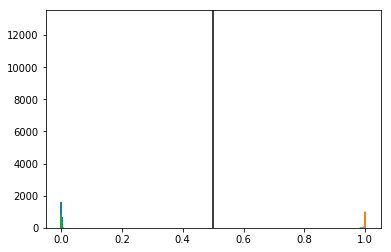

In [105]:
sns.distplot(logistic_regression.predict_proba(X_train[y_train==0])[:,1])
sns.distplot(logistic_regression.predict_proba(X_train[y_train==1])[:,1])
sns.distplot(logistic_regression.predict_proba(X_train[y_train==2])[:,1])
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)

<a id="sec_lr_eval"></a> 
#### Metricas y evaluacion del modelo

[volver a TOC](#section_toc)

In [16]:
y_test_pred = logistic_regression.predict(X_test)

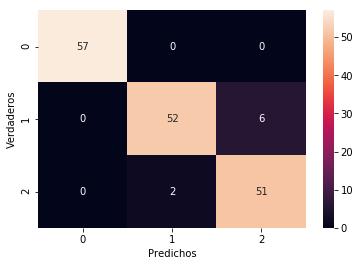

In [17]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

**Classification Report**

In [19]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       0.96      0.90      0.93        58
           2       0.89      0.96      0.93        53

    accuracy                           0.95       168
   macro avg       0.95      0.95      0.95       168
weighted avg       0.95      0.95      0.95       168



**Metricas**

Asigamos variable a la matriz de confusión

In [20]:
TP = cm [2, 2]  # hemos predicho correctamente que el paciente está sano
TN = cm [0, 0]+cm [2, 2] # hemos predicho correctamente que el paciente está enfermo
FP = cm [0, 1]+cm [2, 1]+cm [0, 2] # hemos predicho que le paciente esta sano pero esta enfermo o confundido la enfermedad
FN = cm [1, 0]+cm [1, 2]+cm [2, 0] # hemos predicho que le paciente esta enfermo pero esta sano o confundido la enfermedad

**Accuracy**

(TP + TN) / (TP + TN + FP + FN)

In [114]:
print('Accuracy=', accuracy_score(y_test, y_test_pred).round(2)*100,'%')

Accuracy= 95.0 %


*Conclusión:*  el 95% (aprox.) de los casos —en el test set— han sido clasificados correctamente.

**Sensitivity (o recall)**

TP / TP + FN

In [115]:
recall = (TP / (TP + FN))
print('recall=', (TP / (TP + FN)).round(2)*100,'%')

recall= 89.0 %


*Conclusión:*  nuestro modelo está teniendo un alto rendimiento para detectar pacientes sanos en relación a las que realmente estan sanos.

**Specificity**

TN / (TN + FP)

In [116]:
print('Specificity=', (TN / (TN + FP)).round(2)*100,'%')

Specificity= 98.0 %


*Conclusión:*  nuesto modelo es muy específico, cometió pocos errores de falsos positivos (es decir que pocas veces dijo que un paciente estaba sano, cuando en realidad estaba enfermo).

**Precision**

TP / (TP + FP)

In [117]:
Precision = (TP / (TP + FP))
print('Precision=', (TP / (TP + FP)).round(2)*100,'%')

Precision= 96.0 %


*Conclusión:*  Que nuestro modelo es muy preciso. De cada 100 predicciones positivas que realiza el modelo (es decir, predice que un paciente este sano), acierta 96.

**False positive rate (FPR)**

(1 - Specificity)

In [118]:
print('FPR=', 100-((TN / (TN + FP))).round(2)*100,'%')

FPR= 2.0 %


*Conclusión:* Parece que el indicador es bajo, pero por el caso de negocio se está arriesgando un 2% de vidas.  En el 2% de los casos los clasifica como sanos cuando estan enfermos.

**F1-Score**

2*(Precision * Recall) / precision + Recall

In [119]:
print ('F1-Score=', 2*((Precision * recall) / (Precision + recall)).round(2)*100,'%')

F1-Score= 92.0 %


*Conclusión:*  alto valor de f1_score.  Es decir, es bueno identificando las clases positivas, y preciso.  Aunque por el caso de negocio NO lo suficente

<a id="sec_lr_gs"></a> 
#### Optimizacion de hiperparametros mediante GridSearchCV

[volver a TOC](#section_toc)

In [24]:
grid={"C":np.arange(100, 1000, 100)}
logreg=LogisticRegression(max_iter= 1000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)


In [25]:
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
pd.DataFrame(logreg_cv.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,1.121887,0.063972,0.000000,0.000000,400,{'C': 400},0.960784,0.921569,0.90,0.98,0.84,0.96,0.92,0.98,0.98,0.96,0.940235,0.042862,1
5,1.052014,0.095677,0.003124,0.006248,600,{'C': 600},0.960784,0.921569,0.90,0.98,0.84,0.96,0.92,0.96,0.98,0.96,0.938235,0.041401,2
7,1.038226,0.079979,0.009771,0.007189,800,{'C': 800},0.960784,0.921569,0.92,0.96,0.84,0.94,0.92,0.98,0.98,0.96,0.938235,0.039422,2
8,0.990619,0.081475,0.001561,0.004683,900,{'C': 900},0.960784,0.921569,0.92,0.96,0.84,0.96,0.92,0.96,0.98,0.96,0.938235,0.038393,2
1,1.373746,0.181237,0.001862,0.004672,200,{'C': 200},0.960784,0.921569,0.90,0.98,0.84,0.94,0.92,0.96,0.98,0.96,0.936235,0.040780,5


In [27]:
print(logreg_cv.best_estimator_)
print(logreg_cv.best_score_)
print(logreg_cv.best_params_)

LogisticRegression(C=400, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.9402352941176471
{'C': 400}


**Uso de statsmodels**

Utilizamos las implementaciones de statsmodels para la regresión logística.

In [28]:
import statsmodels.api as sm

In [29]:
X_train_stats = sm.add_constant(X_train)

In [30]:
y_train.sample(10)

61     0
620    2
315    2
626    2
211    1
179    1
178    1
610    2
497    0
283    2
dtype: int32

In [31]:
y_train.replace({1:0.5,2:1}, inplace=True)

In [32]:
logit = sm.Logit(y_train, X_train_stats)


In [ ]:
result = logit.fit()

In [ ]:
print(result.summary2())

In [ ]:
#Hagamos predicciones
X_test_stats = sm.add_constant(X_test)

---

## Automatizacion de procesos

<a id="sec_pipelines"></a> 
### Pipelines

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

[volver a TOC](#section_toc)